In [12]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
dataset_path = '/content/drive/MyDrive/Vehicles'

In [14]:
import os
import matplotlib.pyplot as plt


In [15]:
dataset_path = '/content/drive/MyDrive/Vehicles'  # Replace with your folder path


In [16]:
class_counts = {}

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

print(class_counts)


{}


In [17]:
# 1. Basic imports
!pip -q install pillow pandas matplotlib tqdm

import os, sys, math, json, collections
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
import collections
from pathlib import Path
from PIL import Image, UnidentifiedImageError

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp", ".tif", ".tiff"}

def is_image(p: Path):
    return p.suffix.lower() in VALID_EXTS

def find_splits(root: Path):
    candidates = {"train", "val", "valid", "validation", "test"}
    entries = {d.name.lower(): d for d in root.iterdir() if d.is_dir()}
    splits = []
    for name in candidates:
        if name in entries:
            splits.append((name, entries[name]))
    if splits:
        return splits
    return [("all", root)]

def count_by_class_folder(split_dir: Path):
    counts = collections.Counter()
    broken = collections.Counter()

    class_dirs = [d for d in split_dir.iterdir() if d.is_dir()]

    # Case 1: folder-per-class exists
    if class_dirs:
        for class_dir in class_dirs:
            cls = class_dir.name
            for p in class_dir.rglob("*"):
                if not p.is_file() or not is_image(p):
                    continue
                try:
                    with Image.open(p) as im:
                        im.verify()
                    counts[cls] += 1
                except (UnidentifiedImageError, OSError):
                    broken[cls] += 1
    else:
        # Case 2: images directly under split_dir (no class subfolders)
        cls = split_dir.name
        for p in split_dir.rglob("*"):
            if not p.is_file() or not is_image(p):
                continue
            try:
                with Image.open(p) as im:
                    im.verify()
                counts[cls] += 1
            except (UnidentifiedImageError, OSError):
                broken[cls] += 1

    return counts, broken

# Run
root = Path("/content/drive/MyDrive/Vehicles")
split_dirs = find_splits(root)

all_results = {}
for split_name, split_path in split_dirs:
    counts, broken = count_by_class_folder(split_path)
    all_results[split_name] = {"counts": counts, "broken": broken}

# Preview
for split_name, res in all_results.items():
    print(f"\n=== Split: {split_name} ===")
    print("Total images:", sum(res["counts"].values()))
    if sum(res["broken"].values()) > 0:
        print("Broken/unreadable images:", sum(res["broken"].values()))
    print("Per class counts:", dict(res["counts"]))



=== Split: all ===
Total images: 1602
Per class counts: {'Vehicles': 1602}


Saved plot to: /content/all_class_distribution.png


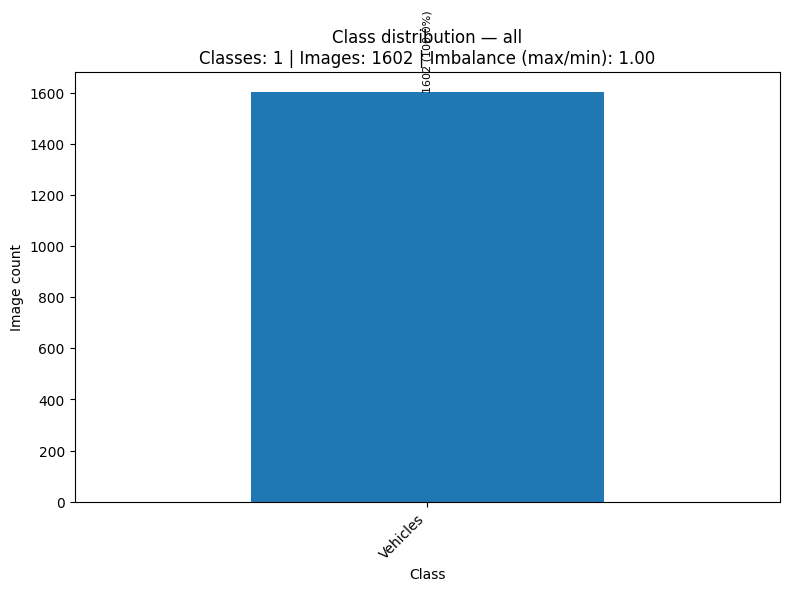

In [19]:
def plot_counts(counter: collections.Counter, title="Class distribution", save_path=None):
    if len(counter) == 0:
        print("No images found.")
        return
    series = pd.Series(counter).sort_values(ascending=False)
    total = series.sum()
    imbalance = series.iloc[0] / max(1, series.iloc[-1])

    plt.figure(figsize=(max(8, len(series)*0.4), 6))
    ax = series.plot(kind="bar")
    ax.set_title(f"{title}\nClasses: {len(series)} | Images: {total} | Imbalance (max/min): {imbalance:.2f}")
    ax.set_xlabel("Class")
    ax.set_ylabel("Image count")
    plt.xticks(rotation=45, ha="right")
    # Annotate bars with percentages
    for p, val in zip(ax.patches, series.values):
        ax.annotate(f"{val} ({val/total:.1%})", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=8, rotation=90)
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print("Saved plot to:", save_path)
    plt.show()

for split_name, res in all_results.items():
    plot_counts(res["counts"], title=f"Class distribution — {split_name}",
                save_path=f"/content/{split_name}_class_distribution.png")

In [23]:
import collections
import pandas as pd

def summary_from_counter(counter: collections.Counter):
    s = pd.Series(counter).sort_values(ascending=False).rename("count")
    total = s.sum()
    out = pd.DataFrame({
        "class": s.index,
        "count": s.values,
        "percent": (s.values/total*100).round(2)
    })
    out["cumulative_%"] = out["percent"].cumsum().round(2)
    return out

# --- Combine all splits ---
combined_counts = collections.Counter()
for split_name, res in all_results.items():
    combined_counts.update(res["counts"])

# --- Create summary ---
summary_all = summary_from_counter(combined_counts)

# Preview
print("\n=== Overall dataset summary ===")
display(summary_all.head(20))  # show top 20 classes

# Save to Excel
excel_path = "/content/overall_class_distribution.xlsx"
summary_all.to_excel(excel_path, index=False, engine="openpyxl")

print(f"\nSaved full summary Excel file: {excel_path}")



=== Overall dataset summary ===


,class,count,percent,cumulative_%
0,Vehicles,1602,100.0,100.0



Saved full summary Excel file: /content/overall_class_distribution.xlsx


In [24]:
from google.colab import files
files.download("/content/class_distribution_summary.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>